# Requirements

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# **Tumor Detection Workflow**

1. **Load the MRI Brain Image**  
   Import the magnetic resonance imaging (MRI) scan of the brain.

2. **Brain Region Extraction**  
   Isolate and extract only the brain region from the MRI image, removing non-brain areas.

3. **Tumor Segmentation**  
   Detect and segment the tumor region from the extracted brain area.

4. **Tumor Size Calculation**  
   Measure and calculate the size (area or volume) of the segmented tumor.

# Load image

Define the path to the image.

In [2]:
image_path = "image-2.jpg"

Read the image.

In [3]:
image = cv2.imread(image_path)

Resize the image to width and height of 256 pixels.

In [4]:
resized_image = cv2.resize(image, (256, 256))

Convert the image from BGR to grayscale.

In [5]:
grayscale_image = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)

Show the image.

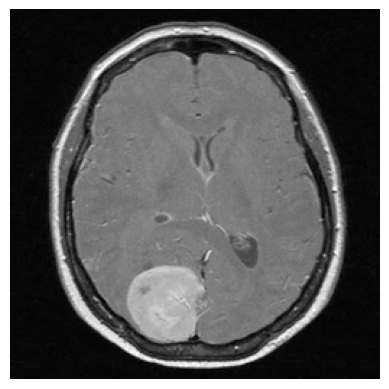

In [6]:
plt.imshow(grayscale_image, cmap="gray")
plt.axis("off");

If the pixels in the image can be classified into two different intensity classes, that is, if they have a bimodal histogram, then **Otsu's method** can be used to threshold them into a binary mask. Let's check that assumption.

Make a histogram of the intensities in the grayscale image.

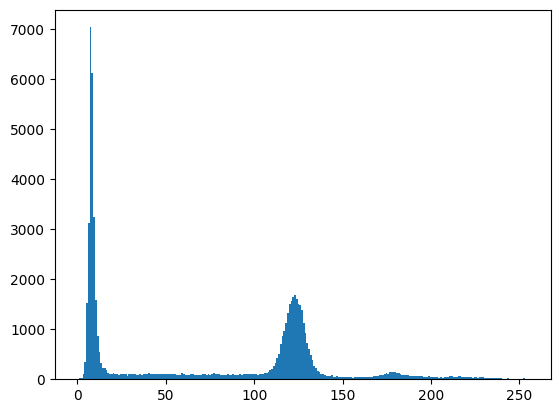

In [7]:
plt.hist(grayscale_image.ravel(),256)
plt.show()

In [8]:
_, thresh = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_OTSU)

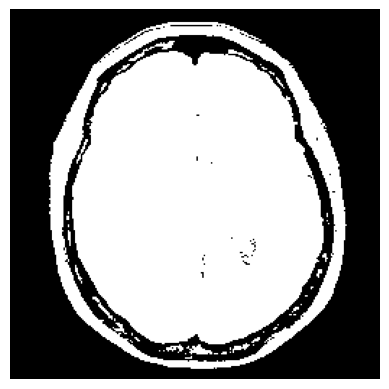

In [9]:
plt.imshow(thresh, cmap="gray")
plt.axis("off");

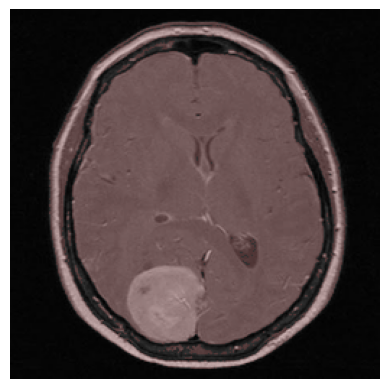

In [10]:
colormask = np.zeros(resized_image.shape, dtype=np.uint8)
colormask[thresh != 0] = np.array((0, 0, 255))
blended = cv2.addWeighted(resized_image, 0.7, colormask, 0.1,0)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.axis("off");

In [11]:
ret, markers = cv2.connectedComponents(thresh)

Get the area taken by each component. Ignore label 0 since this is the background.

In [12]:
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 

Get label of largest component by area.

In [13]:
largest_component = np.argmax(marker_area) + 1 # Add 1 since we dropped zero above.

Get pixels which correspond to the brain.

In [14]:
brain_mask = markers == largest_component

In a copy of the original image, clear those pixels that don't correspond to the brain.

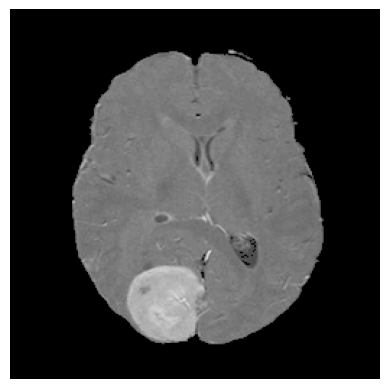

In [15]:
brain_out = resized_image.copy()
brain_out[brain_mask == False] = (0, 0, 0)
plt.imshow(brain_out)
plt.axis("off");

In [16]:
brain_image = cv2.cvtColor(brain_out, cv2.COLOR_BGR2GRAY)

Apply Gaussian blur to the segmented brain.

In [17]:
blurred_image = cv2.GaussianBlur(brain_image, (3, 3), 0)

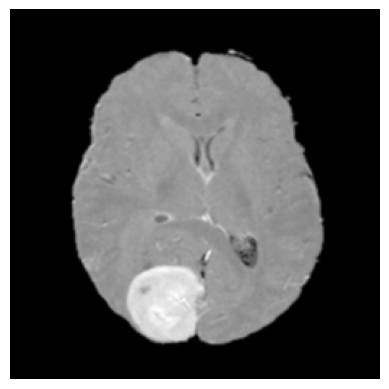

In [18]:
plt.imshow(blurred_image, cmap="gray")
plt.axis("off");

Reshape the image for K-means clustering.

In [19]:
Z = np.float32(blurred_image.reshape((-1,1)))

Define the criteria and apply K-means.

In [20]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3  # Number of clusters (brain, tumor, background).
_, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

Reshape labels to the original image shape.

In [21]:
segmented = labels.reshape(blurred_image.shape).astype("uint8")

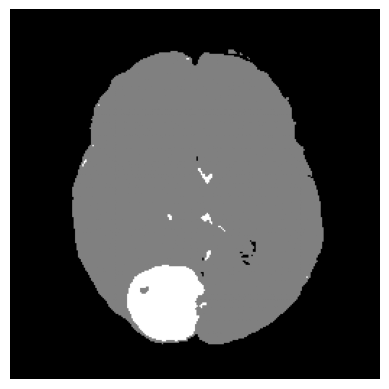

In [22]:
plt.imshow(segmented, cmap="gray")
plt.axis("off");

Convert the tumor cluster to binary mask.

In [23]:
tumor_mask = np.zeros_like(blurred_image)
tumor_mask[segmented == np.argmax(centers)] = 255  # Define the mask.

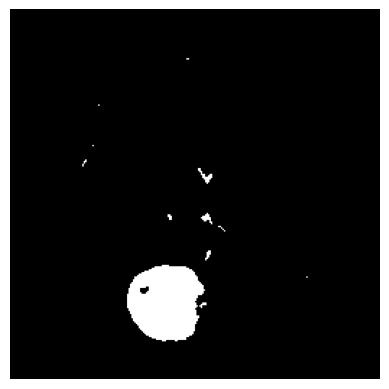

In [24]:
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off");

Perform morphological operations to refine segmentation.

In [25]:
kernel = np.ones((3, 3), np.uint8)
tumor_mask = cv2.morphologyEx(tumor_mask, cv2.MORPH_CLOSE, kernel)

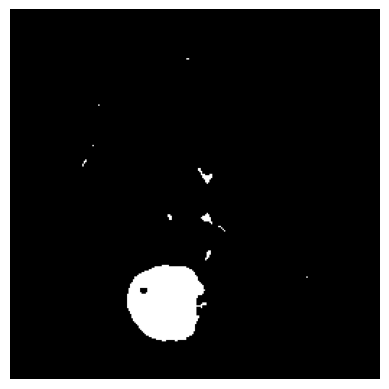

In [26]:
plt.imshow(tumor_mask, cmap="gray")
plt.axis("off");

Find contours and select the largest one (likely the tumor).

In [27]:
contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

Create a final mask for the tumor.

In [28]:
final_mask = np.zeros_like(brain_image)
if contours:
    cv2.drawContours(final_mask, [contours[0]], -1, (255, 0, 0), thickness=cv2.FILLED)

Display the results.

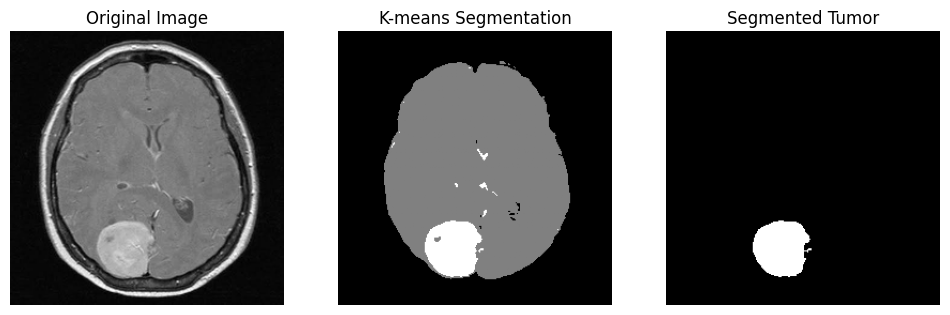

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
plt.axis("off");

plt.subplot(1, 3, 2)
plt.title("K-means Segmentation")
plt.imshow(segmented, cmap="gray")
plt.axis("off");

plt.subplot(1, 3, 3)
plt.title("Segmented Tumor")
plt.imshow(final_mask, cmap="gray")
plt.axis("off");

plt.show()

Extract the contour of the tumor.

In [30]:
tumor_contour = contours[0] # This is the largest contour.
tumor_area_px = cv2.contourArea(tumor_contour)  # Get the area of the largest contour in pixels.

Get bounding box around the tumor.

In [31]:
x, y, w, h = cv2.boundingRect(tumor_contour)

Assume pixel spacing (modify as needed).

In [32]:
pixel_spacing = 0.5  # Example: 0.5 mm per pixel.

Convert area to mm².

In [33]:
tumor_area_mm2 = tumor_area_px * (pixel_spacing ** 2)

In [34]:
print(f"Tumor Size in Pixels: {tumor_area_px} px²")
print(f"Tumor Size in mm²: {tumor_area_mm2:.2f} mm²")
print(f"Tumor Bounding Box: Width={w}px, Height={h}px")

Tumor Size in Pixels: 2104.5 px²
Tumor Size in mm²: 526.12 mm²
Tumor Bounding Box: Width=55px, Height=53px


Draw bounding box around the tumor.

In [35]:
bounding_box = cv2.rectangle(resized_image.copy(), (x, y), (x + w, y + h), (0, 0, 255), 1)

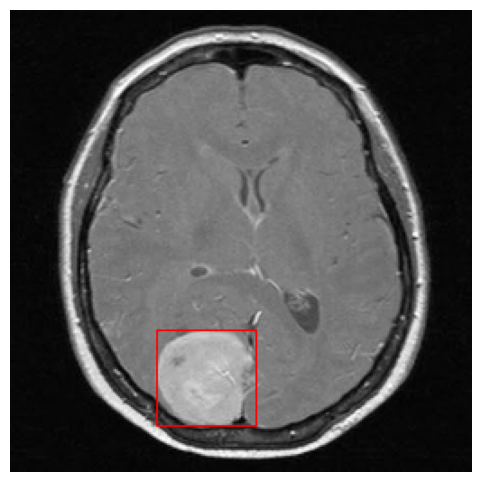

In [36]:
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(bounding_box, cv2.COLOR_BGR2RGBA))
plt.axis("off");

Draw a contour around the tumor.

In [37]:
contour_image = cv2.drawContours(resized_image.copy(), contours, 0, (0, 0, 255), thickness=1)

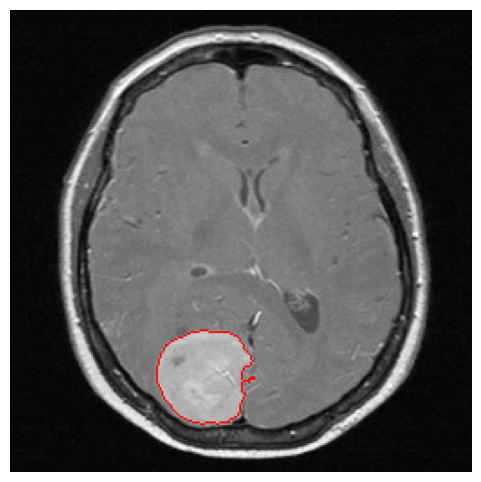

In [38]:
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.axis("off");